<a href="https://colab.research.google.com/github/RiseAboveAll/HealthCare/blob/master/HealthCare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Prerequisites :

- Use Google Colab

- Basic understanding of Machine Learning and specially Trees

- Understanding of Python

### Problem Statement

Congratulations – you have been hired as Chief Data Scientist of MedCamp – a not for profit organization dedicated in making health conditions for working professionals better. MedCamp was started because the founders saw their family suffer due to bad work life balance and neglected health.



MedCamp organizes health camps in several cities with low work life balance. They reach out to working people and ask them to register for these health camps. For those who attend, MedCamp provides them facility to undergo health checks or increase awareness by visiting various stalls (depending on the format of camp). 


MedCamp has conducted 65 such events over a period of 4 years and they see a high drop off between “Registration” and Number of people taking tests at the Camps. In last 4 years, they have stored data of ~110,000 registrations they have done.


One of the huge costs in arranging these camps is the amount of inventory you need to carry. If you carry more than required inventory, you incur unnecessarily high costs. On the other hand, if you carry less than required inventory for conducting these medical checks, people end up having bad experience.


**The Process:**

  1. MedCamp employees / volunteers reach out to people and drive registrations.

  2. During the camp, People who “ShowUp” either undergo the medical tests or visit stalls depending on the format of health camp.

**Other things to note:**
  
  1. Since this is a completely voluntary activity for the working professionals, MedCamp usually has little profile information about these people.

  2. For a few camps, there was hardware failure, so some information about date and time of registration is lost.

  3. MedCamp runs 3 formats of these camps. The first and second format provides people with an instantaneous health score. The third format provides information about several health issues through various awareness stalls.

**Target Variable**

**Favorable outcome:**

  1. For the first 2 formats, a favourable outcome is defined as getting a health_score, while in the third format it is defined as visiting at least a stall.

  2. You need to predict the chances (probability) of having a favourable outcome.


#### Data Description

- Health_Camp_Detail.csv – File containing Health_Camp_Id, Camp_Start_Date, Camp_End_Date and Category details of each camp. https://raw.githubusercontent.com/RiseAboveAll/HealthCare/master/Health_Camp_Detail.csv

- Train.csv – File containing registration details for all the test camps. This includes Patient_ID, Health_Camp_ID, Registration_Date and a few anonymized variables as on registration date. https://raw.githubusercontent.com/RiseAboveAll/HealthCare/master/Train.csv

- Patient_Profile.csv – This file contains Patient profile details like Patient_ID, Online_Follower, Social media details, Income, Education, Age, First_Interaction_Date, City_Type and Employer_Category https://raw.githubusercontent.com/RiseAboveAll/HealthCare/master/Patient_Profile.csv

- First_Health_Camp_Attended.csv – This file contains details about people who attended health camp of first format. This includes Donation (amount) & Health_Score of the person. https://raw.githubusercontent.com/RiseAboveAll/HealthCare/master/First_Health_Camp_Attended.csv

- Second_Health_Camp_Attended.csv - This file contains details about people who attended health camp of second format. This includes Health_Score of the person. https://raw.githubusercontent.com/RiseAboveAll/HealthCare/master/Second_Health_Camp_Attended.csv

- Third_Health_Camp_Attended.csv - This file contains details about people who attended health camp of third format. This includes Number_of_stall_visited & Last_Stall_Visited_Number. https://raw.githubusercontent.com/RiseAboveAll/HealthCare/master/Third_Health_Camp_Attended.csv 

### Information on XGBOOST installation

An alternate way to install XGBoost if you cannot use pip or you want to run the latest code from GitHub requires that you make a clone of the XGBoost project and perform a manual build and installation.

For example to build XGBoost without multithreading on Mac OS X (with GCC already installed via macports or homebrew), you can type:

```

git clone --recursive https://github.com/dmlc/xgboost
cd xgboost
cp make/minimum.mk ./config.mk
make -j4
cd python-package
sudo python setup.py install

```

### Installing and Importing Libraries

In [ ]:
!pip install xgboost

In [ ]:
!pip install --upgrade xgboost

Requirement already up-to-date: xgboost in /usr/local/lib/python3.6/dist-packages (1.1.1)


In [1]:
import pandas as pd
import numpy as np 
import re
import seaborn as sns
from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split as tts
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Above warning is coming because seaborn packages are not updated by the seaborn library maintainer**

### Importing Files For Merging and Creating Final Training Dataset

In [2]:
data_path = "/content/drive/My Drive/HealthCare Analytics/Train/"
fhc = pd.read_csv( data_path + "First_Health_Camp_Attended.csv" )
shc = pd.read_csv( data_path + "Second_Health_Camp_Attended.csv" )
thc = pd.read_csv( data_path + "Third_Health_Camp_Attended.csv" )
print(fhc.shape, shc.shape, thc.shape)

(6218, 5) (7819, 3) (6515, 4)


In [ ]:
fhc.head()

,Patient_ID,Health_Camp_ID,Donation,Health_Score,Unnamed: 4
0,506181,6560,40,0.439024,NaN
1,494977,6560,20,0.097561,NaN
2,518680,6560,10,0.048780,NaN
3,509916,6560,30,0.634146,NaN
4,488006,6560,20,0.024390,NaN


In [3]:
fhc = fhc[['Patient_ID','Health_Camp_ID','Health_Score']]
fhc = fhc.rename(columns={'Health_Score': 'Outcome'})

In [ ]:
fhc.head()

,Patient_ID,Health_Camp_ID,Outcome
0,506181,6560,0.439024
1,494977,6560,0.097561
2,518680,6560,0.048780
3,509916,6560,0.634146
4,488006,6560,0.024390


In [4]:
shc = shc[['Patient_ID','Health_Camp_ID','Health Score']]
shc = shc.rename(columns={'Health Score': 'Outcome'})

In [ ]:
shc.head()

,Patient_ID,Health_Camp_ID,Outcome
0,526631,6536,0.875136
1,509122,6536,0.755700
2,498864,6536,0.673181
3,515398,6536,0.722041
4,504624,6536,0.464712


**Since we want to convert our outcome variable in terms of binary variable , i.e in terms of 0 and 1 hence we rename 'Number_of_stall_visited' Column as Outcome**

In [5]:
thc = thc[['Patient_ID','Health_Camp_ID','Number_of_stall_visited']]
thc = thc[thc['Number_of_stall_visited']>0]
thc = thc.rename(columns={'Number_of_stall_visited': 'Outcome'})
print(fhc.shape, shc.shape, thc.shape)

(6218, 3) (7819, 3) (6497, 3)


In [ ]:
thc.head()

,Patient_ID,Health_Camp_ID,Outcome
0,517875,6527,3
1,504692,6578,1
2,504692,6527,3
3,493167,6527,4
4,510954,6528,2


In [6]:
all_camps = pd.concat([fhc, shc, thc])

**Since all the patients in all_camps dataframe are those who have visited the counter to know their health score , hence we are marking them as 1 in the Outcome variable**

In [7]:
all_camps['Outcome'] = 1
print(all_camps.shape)

(20534, 3)


In [ ]:
all_camps.head()

,Patient_ID,Health_Camp_ID,Outcome
0,506181,6560,1
1,494977,6560,1
2,518680,6560,1
3,509916,6560,1
4,488006,6560,1


In [8]:
all_camps.isna().sum()

Patient_ID        0
Health_Camp_ID    0
Outcome           0
dtype: int64

In [9]:
train = pd.read_csv(data_path + "Train.csv")
print(train.shape)

(75278, 8)


### Merge Train data with all_camps data

In [10]:
train = train.merge(all_camps, on=['Patient_ID','Health_Camp_ID'], how='left')
train['Outcome'] = train['Outcome'].fillna(0).astype('int')

In [ ]:
train.Outcome.value_counts()

0    54744
1    20534
Name: Outcome, dtype: int64

In [ ]:
train.to_csv(data_path+'train_with_outcome.csv', index=False)

**Our  Training Data is prepared now , we will use train_with_outcome.csv for training the model**

In [11]:
Final_Train=pd.read_csv(data_path+'train_with_outcome.csv')

### Finding Anomaly

-  **Reason to replace NaN's to 0 is , the NaNs are present because these registrants have not attended or went to any stalls for awareness or getting health checkup. If you check the number of frequency for Outcome = 0 , it is same as the number of missing values**

In [12]:
Final_Train.isna().sum()

Patient_ID             0
Health_Camp_ID         0
Registration_Date    334
Var1                   0
Var2                   0
Var3                   0
Var4                   0
Var5                   0
Outcome                0
dtype: int64

### Data Prepration

In [ ]:
Final_Train.dtypes

Patient_ID            int64
Health_Camp_ID        int64
Registration_Date    object
Var1                  int64
Var2                  int64
Var3                  int64
Var4                  int64
Var5                  int64
Outcome               int64
dtype: object

In [13]:
idx=Final_Train[Final_Train['Registration_Date'].isna()==True].index

In [ ]:
idx

Int64Index([  328,   784,  1104,  1238,  1339,  1399,  1400,  1401,  1436,
             1819,
            ...
            74601, 74661, 74840, 74900, 74904, 74916, 74978, 75107, 75159,
            75218],
           dtype='int64', length=334)

In [14]:
Final_Train.drop(idx,axis=0,inplace=True)

Convert Registration_Date column to date & time object

In [15]:
Final_Train['Registration_Date']=pd.to_datetime(Final_Train['Registration_Date'], format="%d-%b-%y")

In [ ]:
Final_Train.dtypes

Patient_ID                    int64
Health_Camp_ID                int64
Registration_Date    datetime64[ns]
Var1                          int64
Var2                          int64
Var3                          int64
Var4                          int64
Var5                          int64
Outcome                       int64
dtype: object

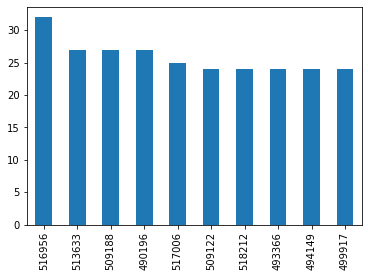

In [ ]:
Final_Train.Patient_ID.value_counts()[:10].plot(kind='bar')


**We see that there are repetition of Patients , which means there are already existing patients who have attended our camp before, they have come to this camp.**



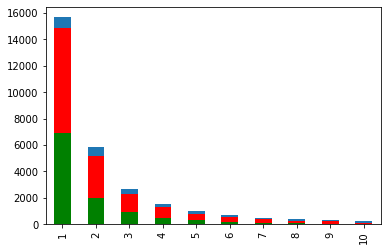

In [ ]:

Final_Train.Patient_ID.value_counts().value_counts()[:10].plot(kind='bar')
Final_Train.Patient_ID[Final_Train.Outcome==0].value_counts().value_counts()[:10].plot(kind='bar',color='r')
Final_Train.Patient_ID[Final_Train.Outcome==1].value_counts().value_counts()[:10].plot(kind='bar',color='g')

**We can see that frequency of new attendees to the camp is much more than the repetitive attendees**

In [ ]:
Final_Train.dtypes

Patient_ID                    int64
Health_Camp_ID                int64
Registration_Date    datetime64[ns]
Var1                          int64
Var2                          int64
Var3                          int64
Var4                          int64
Var5                          int64
Outcome                       int64
dtype: object

### Getting patient details and merging with train

In [16]:
patient = pd.read_csv(data_path + "Patient_Profile.csv", na_values=['None',''])
#Convert First_Interactoion column to date & time object
patient['First_Interaction'] = pd.to_datetime(patient['First_Interaction'], format="%d-%b-%y")

In [17]:
Final_Train = Final_Train.merge(patient, on=['Patient_ID'], how='left')

In [ ]:
Final_Train.shape

(74944, 19)

### Getting health camp details and merging with train

In [18]:
hc = pd.read_csv(data_path + "Health_Camp_Detail.csv")
hc_ids = list(hc.Health_Camp_ID.values)

In [19]:
hc['Camp_Start_Date'] = pd.to_datetime(hc['Camp_Start_Date'], format="%d-%b-%y")
hc['Camp_End_Date'] = pd.to_datetime(hc['Camp_End_Date'], format="%d-%b-%y")

In [20]:
hc['Camp_Duration_Days'] = hc['Camp_End_Date'] - hc['Camp_Start_Date']

In [21]:
hc['Camp_Duration_Days']=hc['Camp_Duration_Days'].dt.days

In [22]:
Final_Train = Final_Train.merge(hc, on=['Health_Camp_ID'], how='left')

### Filling NA with -99 ##

In [ ]:
Final_Train.isna().sum()

Patient_ID                0
Health_Camp_ID            0
Registration_Date         0
Var1                      0
Var2                      0
Var3                      0
Var4                      0
Var5                      0
Outcome                   0
Online_Follower           0
LinkedIn_Shared           0
Twitter_Shared            0
Facebook_Shared           0
Income                53372
Education_Score       65066
Age                   51452
First_Interaction         0
City_Type             33068
Employer_Category     59878
Camp_Start_Date           0
Camp_End_Date             0
Category1                 0
Category2                 0
Category3                 0
Camp_Duration_Days        0
dtype: int64

In [23]:
Final_Train.fillna(-99, inplace=True)

###  Create additional features 

In [24]:
# When did the attendee registered before the camp started or post camp started
Final_Train["Diff_CampStart_Registration"] = Final_Train["Camp_Start_Date"] - Final_Train["Registration_Date"]

In [25]:
Final_Train["Diff_CampStart_Registration"]=Final_Train["Diff_CampStart_Registration"].dt.days

In [26]:
# Did Attendee booked in advance for the camp or how many days earlier did he or she booked for it
Final_Train["Diff_CampEnd_Registration"] = Final_Train["Camp_End_Date"] - Final_Train["Registration_Date"]

In [27]:
Final_Train["Diff_CampEnd_Registration"]=Final_Train["Diff_CampEnd_Registration"].dt.days

In [28]:
# When was the first interaction post registration 
Final_Train["Diff_Registration_FirstInteraction"] = Final_Train["Registration_Date"] - Final_Train["First_Interaction"]

In [29]:
Final_Train["Diff_Registration_FirstInteraction"] = Final_Train["Diff_Registration_FirstInteraction"].dt.days

In [30]:
# How many days it had been for first interaction post camp start
Final_Train["Diff_CampStart_FirstInteraction"] = Final_Train["Camp_Start_Date"] - Final_Train["First_Interaction"]

In [31]:
Final_Train["Diff_CampStart_FirstInteraction"]=Final_Train["Diff_CampStart_FirstInteraction"].dt.days

#### Getitng the category columns and label encode them 

In [33]:
## Getitng the cat columns and label encode them ##
cat_columns = []
for col in Final_Train.columns:
	if Final_Train[col].dtype == 'object':
		print(col)
		cat_columns.append(col)
		enc = preprocessing.LabelEncoder()
		full_list = list(Final_Train[col].values) 
		enc.fit(full_list)
		Final_Train[col] = enc.transform(list(Final_Train[col].values))
		

City_Type
Employer_Category
Category1
Category2


In [34]:
grouped_df=Final_Train.groupby("Patient_ID",as_index=False).agg('size').reset_index()
grouped_df.columns=["Patient_ID","var_count"]
merged_df=pd.merge(Final_Train,grouped_df,how="left",on="Patient_ID")
merged_df.fillna(-1,inplace=True)

In [ ]:
merged_df.head()

,Patient_ID,Health_Camp_ID,Registration_Date,Var1,Var2,Var3,Var4,Var5,Outcome,Online_Follower,LinkedIn_Shared,Twitter_Shared,Facebook_Shared,Income,Education_Score,Age,First_Interaction,City_Type,Employer_Category,Camp_Start_Date,Camp_End_Date,Category1,Category2,Category3,Camp_Duration_Days,Diff_CampStart_Registration,Diff_CampEnd_Registration,Diff_Registration_FirstInteraction,Diff_CampStart_FirstInteraction,var_count
0,489652,6578,2005-09-10,4,0,0,0,2,1,0,0,0,0,-99.0,-99.0,-99.0,2004-12-06,0,0,2005-08-16,2005-10-14,2,6,2,59,-25,34,278,253,10
1,507246,6578,2005-08-18,45,5,0,0,7,0,0,0,0,0,1.0,75.0,40.0,2004-09-08,3,8,2005-08-16,2005-10-14,2,6,2,59,-2,57,344,342,18
2,523729,6534,2006-04-29,0,0,0,0,0,1,0,0,0,0,-99.0,-99.0,-99.0,2004-06-22,0,0,2005-10-17,2007-11-07,1,0,2,751,-194,557,676,482,5
3,524931,6535,2004-02-07,0,0,0,0,0,0,0,0,0,0,-99.0,-99.0,-99.0,2004-02-07,9,0,2004-02-01,2004-02-18,0,4,2,17,-6,11,0,-6,5
4,521364,6529,2006-02-28,15,1,0,0,7,1,0,0,0,1,1.0,70.0,40.0,2003-07-04,9,12,2006-03-30,2006-04-03,1,0,2,4,30,34,970,1000,17


In [ ]:
merged_df.shape

(74944, 30)

In [35]:
Final_Train = Final_Train.sort_values(['Camp_Start_Date', 'Camp_End_Date', 'Patient_ID']).reset_index(drop=True)

In [ ]:
Final_Train.shape

(74944, 29)

### Data Prepration Part 2

In [40]:
Ftrain=Final_Train.merge(merged_df[['Patient_ID','Health_Camp_ID','var_count']],on=['Patient_ID','Health_Camp_ID'],how='right')

In [41]:
Ftrain.shape

(74944, 30)

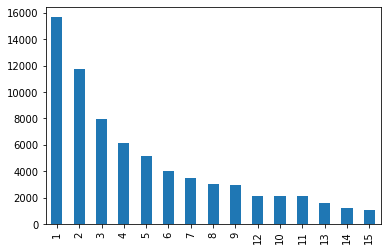

In [ ]:
Ftrain.var_count.value_counts()[:15].plot(kind='bar')

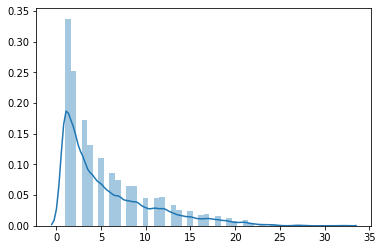

In [ ]:
sns.distplot([Ftrain.var_count])

In [ ]:
Ftrain.var_count.mean()

5.637302519214347

In [42]:
# 1 -> Repeating Patient ; 0-> New Patientt
Ftrain['customer_type']=np.NaN
Ftrain.loc[Ftrain.var_count==1,'customer_type']=0
Ftrain.loc[Ftrain.var_count>1,'customer_type']=1

In [43]:
Ftrain['customer_type'].value_counts()

1.0    59263
0.0    15681
Name: customer_type, dtype: int64

In [44]:
Ftrain.drop('var_count',axis=1,inplace=True)

In [ ]:
Ftrain.dtypes

Patient_ID                                     int64
Health_Camp_ID                                 int64
Registration_Date                     datetime64[ns]
Var1                                           int64
Var2                                           int64
Var3                                           int64
Var4                                           int64
Var5                                           int64
Outcome                                        int64
Online_Follower                                int64
LinkedIn_Shared                                int64
Twitter_Shared                                 int64
Facebook_Shared                                int64
Income                                       float64
Education_Score                              float64
Age                                          float64
First_Interaction                     datetime64[ns]
City_Type                                      int64
Employer_Category                             

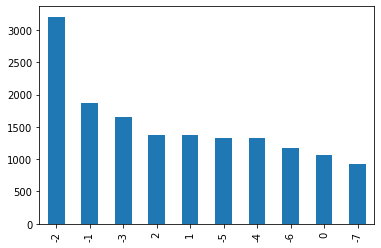

In [ ]:
Ftrain['Diff_CampStart_Registration'].value_counts()[:10].plot(kind='bar')

We can see that people have registered post start of the camp also 

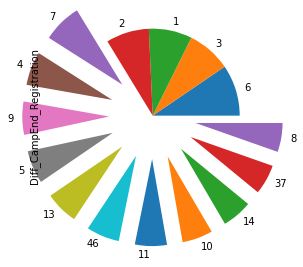

In [ ]:
Final_Train["Diff_CampEnd_Registration"].value_counts()[:15].plot(kind='pie',explode=[0,0,0,0,.5,.5,.5,.5,.5,.5,.5,.5,.5,.5,.5])

We can see there are people who have registered even 1 day before the camp ending day 

In [45]:
# Registration 1- post start of camp ; 0- pre starting of camp
Ftrain['Registration_Type']=np.NaN
Ftrain.loc[Ftrain['Diff_CampStart_Registration']<=0,'Registration_Type']=1
Ftrain.loc[Ftrain['Diff_CampStart_Registration']>0,'Registration_Type']=0

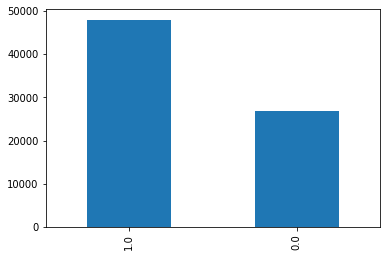

In [46]:
Ftrain['Registration_Type'].value_counts().plot(kind='bar')

We can see there are atleast twice the attendees who have registered after the camp has started

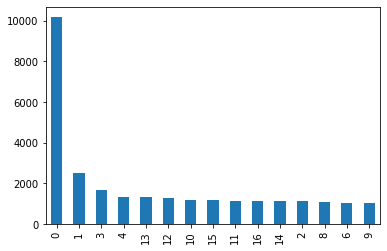

In [ ]:
Final_Train["Diff_Registration_FirstInteraction"].value_counts()[:15].plot(kind='bar')

We see most of them had same day first interaction when they registered

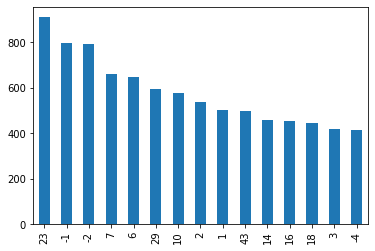

In [ ]:
Final_Train["Diff_CampStart_FirstInteraction"].value_counts()[:15].plot(kind='bar')


We see there are rigstrants who have had first interaction post the camp started , it can be because they have registered post camp has started

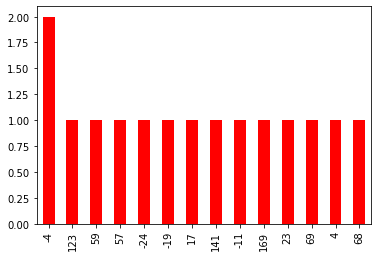

In [ ]:
Final_Train["Diff_CampStart_FirstInteraction"][Ftrain['Registration_Type']==1][:15].value_counts().plot(kind='bar',color='r')

We see though people have registered for the camp post it started but many of them had first interaction before they even started , probably can be an enquiry interaction

In [47]:
# Interaction Type 1-> Post Camp Started ; 0 -> Pre camp started
Ftrain['Interaction_Type']=np.NaN
Ftrain.loc[Final_Train["Diff_CampStart_FirstInteraction"]<=0,'Interaction_Type']=1
Ftrain.loc[Final_Train["Diff_CampStart_FirstInteraction"]>0,'Interaction_Type']=0

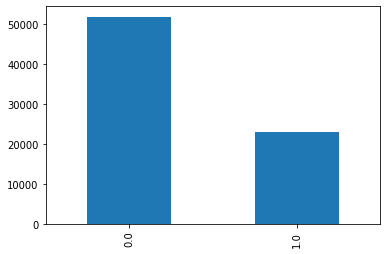

In [48]:
Ftrain['Interaction_Type'].value_counts().plot(kind='bar')

We can see most of the people approximately twice the attendees had their first interaction befor camp start day

In [49]:
Ftrain.drop(['Diff_CampStart_FirstInteraction','Diff_Registration_FirstInteraction','Diff_CampEnd_Registration','Diff_CampStart_Registration'],axis=1,inplace=True)

In [50]:
Ftrain.drop(['Registration_Date','Camp_Start_Date','Camp_End_Date','First_Interaction'],axis=1,inplace=True)

### Normalize Data

In [ ]:
Ftrain.head()

,Patient_ID,Health_Camp_ID,Var1,Var2,Var3,Var4,Var5,Outcome,Online_Follower,LinkedIn_Shared,Twitter_Shared,Facebook_Shared,Income,Education_Score,Age,City_Type,Employer_Category,Category1,Category2,Category3,Camp_Duration_Days,customer_type,Registration_Type,Interaction_Type
0,485751,6530,0,0,0,0,0,0,0,0,0,0,1.0,-99.000000,40.0,2,4,0,2,2,73,1.0,1.0,1.0
1,485826,6530,21,4,0,2,10,0,1,1,0,1,2.0,-99.000000,45.0,6,11,0,2,2,73,1.0,1.0,0.0
2,486115,6530,0,0,0,0,0,0,0,0,0,0,-99.0,-99.000000,-99.0,0,0,0,2,2,73,0.0,1.0,1.0
3,486131,6530,2,0,0,0,1,0,0,0,0,0,-99.0,-99.000000,-99.0,6,0,0,2,2,73,1.0,1.0,0.0
4,486358,6530,5,2,0,0,2,1,0,0,1,0,2.0,83.756667,41.0,3,1,0,2,2,73,1.0,1.0,0.0


In [51]:
# This Function Removes the Outlier
def outlier(Ftrain,col):
    IQR=Ftrain[col].quantile(.75)-Ftrain[col].quantile(.25)
    upper_bound=Ftrain[col].quantile(.75) + ( 1.5 * IQR)
    lower_bound=Ftrain[col].quantile(.25) - ( 1.5 * IQR)
    Ftrain[col].clip(lower=lower_bound,upper=upper_bound,inplace=True)

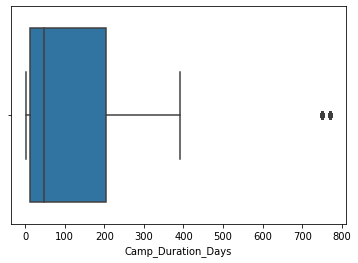

In [52]:
sns.boxplot(Ftrain.Camp_Duration_Days)

In [53]:
outlier(Ftrain,'Camp_Duration_Days')

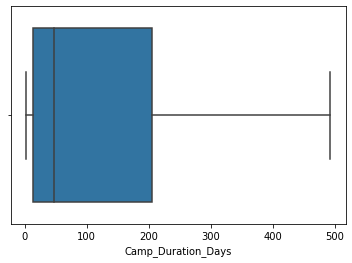

In [54]:
sns.boxplot(Ftrain.Camp_Duration_Days)

In [55]:
num_col=['Var1','Var2','Var3','Var4','Var5','Education_Score','Age','Camp_Duration_Days']

In [56]:
norm=preprocessing.Normalizer().fit_transform(Ftrain[num_col])

In [57]:
norm=pd.DataFrame(norm,columns=num_col)

In [58]:
Ftrain.drop(num_col,axis=1,inplace=True)
Ftrain=pd.concat([Ftrain,norm],axis=1)

In [ ]:
Ftrain.head()

,Patient_ID,Health_Camp_ID,Outcome,Online_Follower,LinkedIn_Shared,Twitter_Shared,Facebook_Shared,Income,City_Type,Employer_Category,Category1,Category2,Category3,customer_type,Registration_Type,Interaction_Type,Var1,Var2,Var3,Var4,Var5,Education_Score,Age,Camp_Duration_Days
0,485751,6530,0,0,0,0,0,1.0,2,4,0,2,2,1.0,1.0,1.0,0.000000,0.000000,0.0,0.000000,0.000000,-0.765398,0.309252,0.564384
1,485826,6530,0,1,1,0,1,2.0,6,11,0,2,2,1.0,1.0,0.0,0.157774,0.030052,0.0,0.015026,0.075131,-0.743793,0.338088,0.548454
2,486115,6530,0,0,0,0,0,-99.0,0,0,0,2,2,0.0,1.0,1.0,0.000000,0.000000,0.0,0.000000,0.000000,-0.626997,-0.626997,0.462331
3,486131,6530,0,0,0,0,0,-99.0,6,0,0,2,2,1.0,1.0,0.0,0.012665,0.000000,0.0,0.000000,0.006333,-0.626934,-0.626934,0.462285
4,486358,6530,1,0,0,1,0,2.0,3,1,0,2,2,1.0,1.0,0.0,0.042170,0.016868,0.0,0.000000,0.016868,0.706407,0.345795,0.615685


In [59]:
Ftrain.drop(['Patient_ID','Health_Camp_ID'],axis=1,inplace=True)

### Splitting the Data Set

In [60]:
X_Data=Ftrain.drop('Outcome',axis=1)
y_data=Ftrain[['Outcome']]

In [ ]:
X_Data.shape

(74944, 21)

In [69]:
X_train,X_test,y_train,y_test=tts(X_Data,y_data,test_size=.20,random_state=2)

### Important Feature Selection

In [67]:
FS_clf=DTC(criterion='gini').fit(X_train,y_train)

In [ ]:
len(FS_clf.feature_importances_)

21

In [70]:
cols=X_train.columns
impo=FS_clf.feature_importances_
FI=pd.DataFrame(cols,columns=['Columns'])
FI['Importance']=impo

In [ ]:
FI

,Columns,Importance
0,Online_Follower,0.007150
1,LinkedIn_Shared,0.010600
2,Twitter_Shared,0.010536
3,Facebook_Shared,0.007623
4,Income,0.035356
5,City_Type,0.072385
6,Employer_Category,0.039492
7,Category1,0.348454
8,Category2,0.013406
9,Category3,0.001885


In [72]:
FS_clf=DTC(criterion='gini')
rfe = RFE(FS_clf, 3)
rfe = rfe.fit(X_train, y_train.values.ravel())
# print summaries for the selection of attributes
print(X_train.columns)
print(rfe.ranking_)

Index(['Online_Follower', 'LinkedIn_Shared', 'Twitter_Shared',
       'Facebook_Shared', 'Income', 'City_Type', 'Employer_Category',
       'Category1', 'Category2', 'Category3', 'customer_type',
       'Registration_Type', 'Interaction_Type', 'Var1', 'Var2', 'Var3', 'Var4',
       'Var5', 'Education_Score', 'Age', 'Camp_Duration_Days'],
      dtype='object')
[16  9 12 14  7  4  5  1 10 18 13  2 11  6 15 19 17  8  3  1  1]


In [ ]:
rfe.support_

array([False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True])

### Baseline Model

In [ ]:
selected_data=X_train[['Category1', 'Age', 'Camp_Duration_Days']]

In [ ]:
clf=DTC(criterion='entropy').fit(selected_data,y_train)

In [ ]:
y_pred=clf.predict(selected_data)

In [ ]:
print(classification_report(y_train,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.91      0.89     43687
           1       0.72      0.66      0.69     16268

    accuracy                           0.84     59955
   macro avg       0.80      0.78      0.79     59955
weighted avg       0.84      0.84      0.84     59955



In [ ]:
selected_data_t=X_test[['Category1', 'Age', 'Camp_Duration_Days']]

In [ ]:
y_pred_t=clf.predict(selected_data_t)

In [ ]:
print(classification_report(y_test,y_pred_t))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85     10919
           1       0.60      0.55      0.58      4070

    accuracy                           0.78     14989
   macro avg       0.72      0.71      0.71     14989
weighted avg       0.78      0.78      0.78     14989



** We see there is overfitting in te model**

### XGBOOST

- XGBoost is an implementation of gradient boosted decision trees designed for speed and performance that is dominative competitive machine learning.

**What is XGBOOST?**

XGBoost is a decision-tree-based ensemble Machine Learning algorithm that uses a gradient boosting framework. In prediction problems involving unstructured data (images, text, etc.) artificial neural networks tend to outperform all other algorithms or frameworks. However, when it comes to small-to-medium structured/tabular data, decision tree based algorithms are considered best-in-class right now.

Evolution of tree-based algorithms over the years :


![alt text](https://miro.medium.com/max/700/1*QJZ6W-Pck_W7RlIDwUIN9Q.jpeg)

The algorithm differentiates itself in the following ways:

- A wide range of applications: Can be used to solve regression, classification, ranking, and user-defined prediction problems.

- Portability: Runs smoothly on Windows, Linux, and OS X.

- Languages: Supports all major programming languages including C++, Python, R, Java, Scala, and Julia.

- Cloud Integration: Supports AWS, Azure, and Yarn clusters and works well with Flink, Spark, and other ecosystems.

**How to build an intuition for XGBoost?**

Imagine that you are a hiring manager interviewing several candidates with excellent qualifications. Each step of the evolution of tree-based algorithms can be viewed as a version of the interview process.


- **Decision Tree**: Every hiring manager has a set of criteria such as education level, number of years of experience, interview performance. A decision tree is analogous to a hiring manager interviewing candidates based on his or her own criteria.

- **Bagging**: Now imagine instead of a single interviewer, now there is an interview panel where each interviewer has a vote. Bagging or bootstrap aggregating involves combining inputs from all interviewers for the final decision through a democratic voting process.

- **Random Forest**: Every interviewer will only test the interviewee on certain randomly selected qualifications (e.g. a technical interview for testing programming skills and a behavioral interview for evaluating non-technical skills).

- **Boosting**: This is an alternative approach where each interviewer alters the evaluation criteria based on feedback from the previous interviewer. This ‘boosts’ the efficiency of the interview process by deploying a more dynamic evaluation process.

- **Gradient Boosting**: A special case of boosting where errors are minimized by gradient descent algorithm e.g. the strategy consulting firms leverage by using case interviews to weed out less qualified candidates.

- **XGBoost**: Think of XGBoost as gradient boosting on ‘steroids’ (well it is called ‘Extreme Gradient Boosting’ for a reason!). It is a perfect combination of software and hardware optimization techniques to yield superior results using less computing resources in the shortest amount of time.

**Why does XGBoost perform so well?**

XGBoost and Gradient Boosting Machines (GBMs) are both ensemble tree methods that apply the principle of boosting weak learners (CARTs generally) using the gradient descent architecture. However, XGBoost improves upon the base GBM framework through systems optimization and algorithmic enhancements.

![alt text](https://miro.medium.com/max/700/1*FLshv-wVDfu-i54OqvZdHg.png)

- **System Optimization:**

  1. Parallelization: XGBoost approaches the process of sequential tree building using parallelized implementation. This is possible due to the interchangeable nature of loops used for building base learners; the outer loop that enumerates the leaf nodes of a tree, and the second inner loop that calculates the features. This nesting of loops limits parallelization because without completing the inner loop (more computationally demanding of the two), the outer loop cannot be started. Therefore, to improve run time, the order of loops is interchanged using initialization through a global scan of all instances and sorting using parallel threads. This switch improves algorithmic performance by offsetting any parallelization overheads in computation.

  2. Tree Pruning: The stopping criterion for tree splitting within GBM framework is greedy in nature and depends on the negative loss criterion at the point of split. XGBoost uses ‘max_depth’ parameter as specified instead of criterion first, and starts pruning trees backward. This ‘depth-first’ approach improves computational performance significantly.

**Algorithmic Enhancements:**

  1. Regularization: It penalizes more complex models through both LASSO (L1) and Ridge (L2) regularization to prevent overfitting.

  2. Sparsity Awareness: XGBoost naturally admits sparse features for inputs by automatically ‘learning’ best missing value depending on training loss and handles different types of sparsity patterns in the data more efficiently.

  3. Weighted Quantile Sketch: XGBoost employs the distributed weighted Quantile Sketch algorithm to effectively find the optimal split points among weighted datasets.

  4. Cross-validation: The algorithm comes with built-in cross-validation method at each iteration, taking away the need to explicitly program this search and to specify the exact number of boosting iterations required in a single run.

It is not that we start with XGBOOST.

When it comes to Machine Learning, there is no free lunch. We must test all possible algorithms for data at hand to identify the best algorithm. Besides, picking the right algorithm is not enough. We must also choose the right configuration of the algorithm for a dataset by tuning the hyper-parameters. Furthermore, there are several other considerations for choosing the winning algorithm such as computational complexity, explainability, and ease of implementation. This is exactly the point where Machine Learning starts drifting away from science towards art, but honestly, that’s where the magic happens!

#### Important Features

In [ ]:

# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)
model.feature_importances_

array([0.00704725, 0.00740983, 0.00710735, 0.00525888, 0.01389796,
       0.00702535, 0.00671355, 0.6188404 , 0.01871728, 0.01202048,
       0.03814477, 0.17678602, 0.01103632, 0.00737959, 0.00696372,
       0.00183983, 0.00488374, 0.00763458, 0.00963189, 0.0175083 ,
       0.01415287], dtype=float32)

In [ ]:
cols=X_train.columns
impo=model.feature_importances_
FI=pd.DataFrame(cols,columns=['Columns'])
FI['Importance']=impo

In [ ]:
FI

,Columns,Importance
0,Online_Follower,0.007047
1,LinkedIn_Shared,0.007410
2,Twitter_Shared,0.007107
3,Facebook_Shared,0.005259
4,Income,0.013898
5,City_Type,0.007025
6,Employer_Category,0.006714
7,Category1,0.618840
8,Category2,0.018717
9,Category3,0.012020


### XGBOOST without Important Features 

In [ ]:

# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Prediction

In [ ]:
y_pred=model.predict(X_train)

Classification Report on In-Sample Evaluation

In [ ]:
print(classification_report(y_train,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.92      0.90     43687
           1       0.75      0.63      0.69     16268

    accuracy                           0.84     59955
   macro avg       0.81      0.78      0.79     59955
weighted avg       0.84      0.84      0.84     59955



Prediction on Test Data

In [ ]:
y_pred_t=model.predict(X_test)

Classification Report on Out-Sample Evalutation

In [ ]:
print(classification_report(y_test,y_pred_t))

              precision    recall  f1-score   support

           0       0.85      0.90      0.88     10919
           1       0.70      0.59      0.64      4070

    accuracy                           0.82     14989
   macro avg       0.78      0.75      0.76     14989
weighted avg       0.81      0.82      0.81     14989



### XGBOOST Model with Important Features

In [73]:
# fit model no training data
model = XGBClassifier()
rfe = RFE(model, 5)
rfe = rfe.fit(X_train, y_train.values.ravel())
# print summaries for the selection of attributes
print(X_train.columns)
rfe.support_

Index(['Online_Follower', 'LinkedIn_Shared', 'Twitter_Shared',
       'Facebook_Shared', 'Income', 'City_Type', 'Employer_Category',
       'Category1', 'Category2', 'Category3', 'customer_type',
       'Registration_Type', 'Interaction_Type', 'Var1', 'Var2', 'Var3', 'Var4',
       'Var5', 'Education_Score', 'Age', 'Camp_Duration_Days'],
      dtype='object')


array([False, False, False, False,  True, False, False,  True,  True,
       False,  True,  True, False, False, False, False, False, False,
       False, False, False])

In [74]:
#Create Model Object
model = XGBClassifier()
#Select Important Features for train data
selected_data=X_train[['Income','Category1', 'Category2', 'customer_type','Registration_Type']]
model.fit(selected_data,y_train.values.ravel())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [75]:
#Prediction on training data
y_pred=model.predict(selected_data)

In [76]:
# Classification Report for in-sample evaluation
print(classification_report(y_train,y_pred))


              precision    recall  f1-score   support

           0       0.84      0.92      0.88     43687
           1       0.72      0.53      0.61     16268

    accuracy                           0.82     59955
   macro avg       0.78      0.73      0.75     59955
weighted avg       0.81      0.82      0.81     59955



In [ ]:
#Select Important Features for test data
selected_data_t=X_test[['Income','Category1', 'Category2', 'customer_type','Registration_Type']]

In [ ]:
#Prediction on Test data
y_pred_t=model.predict(selected_data_t)
# Classification Report for Out of Sample Evaluation
print(classification_report(y_test,y_pred_t))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88     10919
           1       0.71      0.54      0.62      4070

    accuracy                           0.82     14989
   macro avg       0.78      0.73      0.75     14989
weighted avg       0.81      0.82      0.81     14989

